In [20]:
#Takes 100 years to import
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
figsize(15, 5)
import math

In [2]:
'''
In this file I will compare 2 methods for calculating the nth fibonacci number
Fibonacci Sequence: 1 1 2 3 5 8 13 ... f(n) = f(n-1)+f(n-2)


1) Iterative solution using a loop

2) Recursive solution

3) Fully correct linear algebra solution

4) Improved linear algebra solution with factorized matrix

5) Linear algebra solution adapted to be an explicit formula

'''

# The following notes are more for me than for you, feel free to read them, although it's a little lengthy


'''
I don't think my approach is wrong, but I'm being constrained by the data types. I will need to find a solution.
Here's some of the sources that I've found that seem to suggest I'm using the correct approach:
http://www.math.hawaii.edu/~pavel/fibonacci.pdf
https://medium.com/@andrew.chamberlain/the-linear-algebra-view-of-the-fibonacci-sequence-4e81f78935a3
http://web.media.mit.edu/~holbrow/post/calculating-fibonacci-numbers-with-matrices-and-linear-algebra/
'''
# even copying the exact 'solution' from the 3rd website listed gives the exact same error. shown below
lmbd_1 = (1+np.sqrt(5))/2
lmbd_2 = (1-np.sqrt(5))/2

a       = np.matrix([[1,      1],      [1,  0]])
s       = np.matrix([[lmbd_1, lmbd_2], [1,  1]])
s_inv   = np.matrix([[1,     -lmbd_2], [-1, lmbd_1]]) * (1/np.sqrt(5))
eig_val = np.matrix([[lmbd_1, 0],      [0,  lmbd_2]])
u_0     = np.matrix([[1],              [0]])

def eig_k(k):
    return eig_val ** k

def u_k(k):
    return s * eig_k(k) * s_inv * u_0

def fib_incorrect_solution(n):
    f_n = u_k(n)[1,0]
    return int(round(f_n))

print()

# Fib 1
Simple iterative approach

In [3]:
def fib_1(n):
    prev = 0
    current = 1
    while n>1:
        temp = current
        current += prev
        prev = temp
        n -= 1
    return current

# Fib 2
Recursive Solution

In [4]:
def fib_2_helper(prev,curr,n):
    if n>0: return fib_2_helper(curr, prev+curr, n-1)
    else: return curr

def fib_2(n):
    #fib_2 will need a helper function for the recursion
    return fib_2_helper(0,1,n-1)

# Fib 3
Simple Linear Algebra

In [5]:
'''

The third approach to fibonacci is based on matrix multiplication. For the sake of my understanding of this topic,
I have included additional examples that illustrate how the matrix_power portion of this works

The basic format of this approrach is to find a matrix 'A' and exponent 'x', which when multiplied by [0 1] returns fib(n)



NAIVE APPROACH

To begin naively, we can use the matrix A = [0 1 / 1 1] and let the exponent x = n.
This will give the formula (A^n)*([0 1]) = [Fib(n-1), Fib(n)]
If you were to ask for the 4th fibonacci number using this approach, the result will be the 2nd value of the matrix [2 3]
This is demonstrated below in the method fib_3_naive

'''

def fib_3_naive(n):
    fib_matrix = np.matrix('0 1; 1 1.')
    start = np.matrix('0 1')
    #print(np.linalg.matrix_power(fib_matrix.A, n).dot(start.A.T))
    return np.linalg.matrix_power(fib_matrix.A, n-1).dot(start.A.T)[1][0]

'''

CORRECT FOR ALL N

The naive approach is only bad because it generates values which are not actually useful in the solution (n-1).
It also uses n as the exponent, which can get large very quickly (it would be nice to reduce this if possible).

To do this, we can square the A from the naive approach, which will essentially compute the next 2 fibonacci numbers at once
The implementation of this idea is fib_3 below

'''

def fib_3(n):
    fib_matrix = np.matrix('1. 1;1 2')
    start = np.matrix('0 1')
    #print(np.linalg.matrix_power(fib_matrix.A, (n-1)//2))
    return np.linalg.matrix_power(fib_matrix.A, n//2).dot(start.A.T)[(n+1)%2-1][0]


'''

While I was discussing the previous approach with a friend, he suggested that we could square the matrix again to speed it up
We tried this, and it seemed to work, but there are some very notable issues. I'll explain the approach better:
The matrix we were using was [2 3/3 5], which is 'A' from the naive approach, raised to the 4th power (squared then squared)

This is accurate if n%4 is equal to 0 or 1, otherwise the returned value is incorrect.
The incorrect values are previous, correct values (ex: 0 1 0 1 3 5 3 5 21 34 21 34)

I figured that maybe there would be some sort of pattern using A^3 as well, but was not able to get anything working
It seems that this approach will improve the efficiency if you want a very large number satisfying the n%4 requirements.


However, after testing fib_3 with the newly suggested method, I saw very little improvement.
There was also very little improvement when switching from the naive linalg approach to the standard one.


'''

def fib_3_suggested_by_friend(n):
    fib_matrix = np.matrix('2 3;3 5.')
    # fib_matrix = np.matrix('1 2;2 3.')
    start = np.matrix('0 1.')
    # print(np.linalg.matrix_power(fib_matrix.A, (n-1)//4)
    return np.linalg.matrix_power(fib_matrix.A, n//4).dot(start.A.T)[(n+1)%2-1][0]

In [6]:
# Throws a value error
# fib_incorrect_solution(1500)

# for i in range(12):
#    print(i, fib_3_suggested_by_friend(i))

# print(fib_3_suggested_by_friend(1200) == fib_3(1200))
# True

# %timeit fib_3_suggested_by_friend(1200)

# %timeit fib_3(1200)

# Fib 4
Factorized linalg approach

In [7]:
'''
The previous functions were all written with help of Dr. Blanco-Silva.
The assignment in part 15, as written, is to create a fibonacci function
using PDP^(-1), as well as one that works using formulas.


For fib_4, I realized that LDU factorization is not applicable here. Instead, (I believe) I
need to use eigen factorization.

Eigen factorization results in VDV^-1, where D is a diagonal matrix of eigen values and the columns
of V are the eigen vectors.
'''

#NOTE: I've been trying to resist googling simply 'fibonacci linear algebra approach'

'''
https://en.wikipedia.org/wiki/Matrix_decomposition

The final comment from the eigen factorization section is, I believe, the part that is relevant here:
Given an equation where x_t+1 = A*x_t, this can also be solved by x_t = A^t*x_0. However, if you use eigen factorization,
the formula becomes: x_t = V(D^t)V^-1*x_0. The advantage to this approach is that the values of D can be raised to the
't' power, which is significantly less expensive than raising a matrix to the 't' power. 

With this comment in mind, we can improve the efficiency of fib_3 by factorizing fib_matrix before the exponent
'''


# It is worth noting that fib_4 is less accurate than the previous approaches
def fib_4(n):
    # I usually like 1 liners, I'm not sure if its actually more efficient
    

    fib_matrix = np.matrix('1 1; 1 2.')
    start = np.matrix('0 1.')
    D,V = np.linalg.eig(fib_matrix)
    
    # the eigen values are stored in a 1D array, super easy to make it a diagonal matrix if you want that
    # D = np.diag(D)   # not yet tho
    
    # Vinv = np.linalg.inv(V)
    # final_mat = V*(np.diag(D**((n-1)//2)))*Vinv
    # return final_mat.dot(start.A.T)[n%2-1][0]
    
    return (V*(np.diag((D**(n//2)))*np.linalg.inv(V))).dot(start.A.T).A[(n+1)%2-1][0]

# Fib 5
Formula Expression

In [42]:
'''
In the face of adversity we perservere. In this case, we can still improve the efficiency by finding the formulaic solution.

full disclosure: I'm learning this from the link:
http://www.math.hawaii.edu/~pavel/fibonacci.pdf
Which discusses kepler's obervation.
'''
# prepping the formula
# NOTE: most of the timeit comparisons I've seen show the standard ** to be faster than any .pow function in a package
# those functions are bad for efficiency, good for accuracy/flexibility (as far as I know)
def fib_5(n):
    Phi = (1+math.sqrt(5))/2
    phi = (1-math.sqrt(5))/2
    return (Phi**n-phi**n)/(math.sqrt(5))

In [9]:
print('Testing the fib methods:\n1) {0}\n2) {1}\n3) {2}\n4) {3}\n5) {4}'.format(fib_1(5),fib_2(6),fib_3(7),\
                                                                                fib_4(8), fib_5(9)))

Testing the fib methods:
1) 5
2) 8
3) 13.0
4) 21.000000000000004
5) 34


In [10]:
# http://mortada.net/fibonacci-numbers-in-python.html

elapsed = {}
elapsed[1] = {}
elapsed[2] = {}
elapsed[3] = {}
elapsed[4] = {}
elapsed[5] = {}

for i in range(34):
    result = %timeit -n 500 -q -o fib_1(i)
    elapsed[1][i] = result.best
    result = %timeit -n 500 -q -o fib_2(i)
    elapsed[2][i] = result.best
    result = %timeit -n 500 -q -o fib_3(i)
    elapsed[3][i] = result.best
    result = %timeit -n 500 -q -o fib_4(i)
    elapsed[4][i] = result.best
    result = %timeit -n 500 -q -o fib_5(i)
    elapsed[5][i] = result.best



Text(0.5,0,'n')

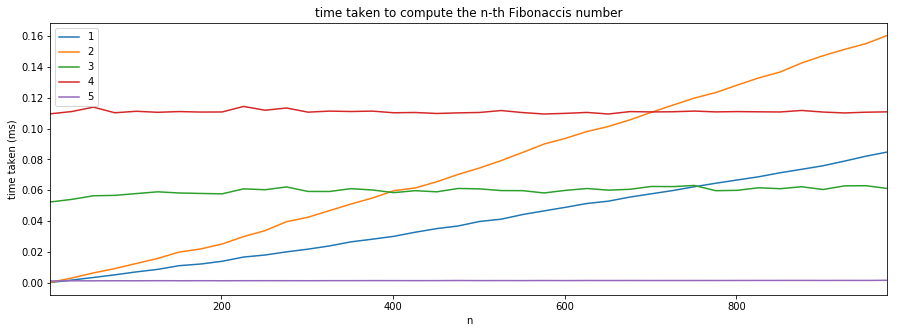

In [21]:
elapased_ms = pd.DataFrame(elapsed) * 1000
elapased_ms.plot(title='time taken to compute the n-th Fibonaccis number')
plt.ylabel('time taken (ms)')
plt.xlabel('n')

In [14]:
# While methods 3 and 4 start much slower, they scale better.
elapsed = {}
elapsed[1] = {}
elapsed[2] = {}
elapsed[3] = {}
elapsed[4] = {}
elapsed[5] = {}

for i in range(1,1000,25):
    result = %timeit -n 2000 -q -o fib_1(i)
    elapsed[1][i] = result.best
    result = %timeit -n 2000 -q -o fib_2(i)
    elapsed[2][i] = result.best
    result = %timeit -n 2000 -q -o fib_3(i)
    elapsed[3][i] = result.best
    result = %timeit -n 2000 -q -o fib_4(i)
    elapsed[4][i] = result.best
    result = %timeit -n 2000 -q -o fib_5(i)
    elapsed[5][i] = result.best


Text(0.5,0,'n')

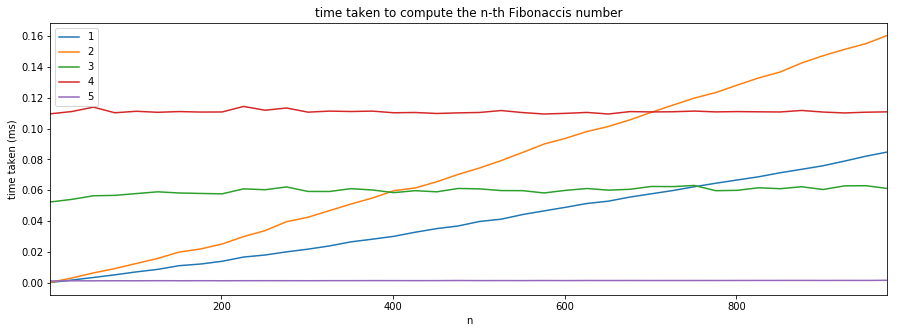

In [22]:
elapased_ms = pd.DataFrame(elapsed) * 1000
elapased_ms.plot(title='time taken to compute the n-th Fibonaccis number')
plt.ylabel('time taken (ms)')
plt.xlabel('n')

In [32]:
# more accurately comparing methods 3,4,5 at values 1000+
elapsed = {}
elapsed[3] = {}
elapsed[4] = {}
elapsed[5] = {}

for i in range(1000,1400,5):
    result = %timeit -n 5000 -q -o fib_3(i)
    elapsed[3][i] = result.best
    result = %timeit -n 5000 -q -o fib_4(i)
    elapsed[4][i] = result.best
    result = %timeit -n 5000 -q -o fib_5(i)
    elapsed[5][i] = result.best


Text(0.5,0,'n')

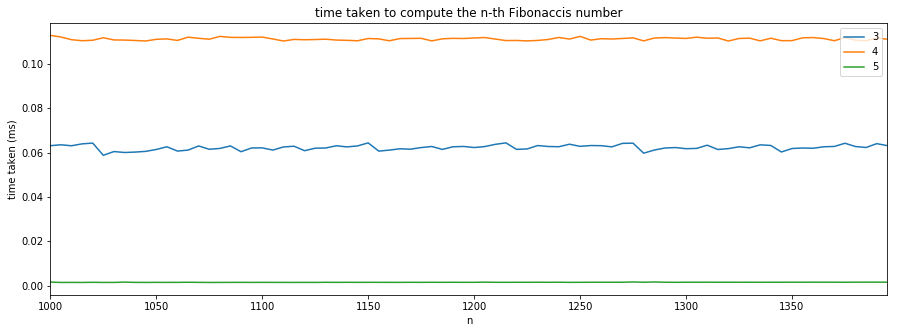

In [34]:
elapased_ms = pd.DataFrame(elapsed) * 1000
elapased_ms.plot(title='time taken to compute the n-th Fibonaccis number')
plt.ylabel('time taken (ms)')
plt.xlabel('n')

# It is kinda tough to see but fib 3 is increasing faster than fib 4

# STOP HERE
Below this point is old stuff and the file is a mess

In [ ]:
# %timeit fib_1(100000)
%timeit fib_5(1000)

In [12]:
# While I know it's possible, I couldn't think of an elegant way to create a single method
# that would be able to time either fib1 or fib2 but not both at the same time. Instead,
# I will create separate methods (They will probably need different settings on timeit anyway)

# Both of the timer methods output to .txt files ultimately, things printed in this doc are for testing

'''
NOTE: Replace this crap with something like this

http://mortada.net/fibonacci-numbers-in-python.html
'''


from timeit import repeat

def fib_1_timeval(val, repetitions):
    setup = '''from __main__ import fib_1'''
    
    my_code = '''fib_1({0})'''.format(val)
    
    return timeit(setup=setup, stmt=my_code, number=repetitions)/repetitions

def fib_2_timeval(val, repetitions):
    setup = '''
from __main__ import fib_2
sys.setrecursionlimit(10**7)'''
    
    my_code = '''fib_2({0})'''.format(val)
    
    return timeit(setup=setup, stmt=my_code, number=repetitions)/repetitions

0.0001105803716808893

0.0011776242063371925

In [15]:
# The next step is to automatically time an entire range of values.
# This brings up questions about syntax, would it be preferable to pass in a list of values to test?
# Perhaps a start val, end val, and a step between them? could be handled by range() + first construct
# How to set the precision of each value? -- for now I'll use the same for everything

def fib_1_timer(reps=10, startInd=1, endInd=1000, step=10):
    with open('fib1_times.txt','w') as write_file:
        for n in range(startInd, endInd+1, step):
            write_file.write('{0}\t{1}\n'.format(n,fib_1_timeval(n,reps)))
            
def fib_2_timer(reps=10, startInd=1, endInd=1000, step=10):
    with open('fib2_times.txt','w') as write_file:
        for n in range(startInd, endInd+1, step):
            write_file.write('{0}\t{1}\n'.format(n,fib_2_timeval(n,reps)))

In [16]:
# Even with 50 trials each repetition, there is significant variance
# But still pretty good.
# fib_1_timer(500,0,3000,5)
# fib_2_timer(500,0,3000,5)

In [17]:
# Now I will create a method to read the files I created and graph the data
def graph_data(inFile):
    x = []
    y = []
    with open(inFile, 'r') as in_file:
        for line in in_file:
            tmp = re.split(r'\t', line)
            x.append(float(tmp[0]))
            y.append(float(tmp[1]))
            
    plt.ylim(0,y[-1]*1.2)
    
    plt.scatter(x, y)
    plt.show()


In [ ]:
graph_data('fib1_times.txt')

In [ ]:
graph_data('fib2_times.txt')